<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson7/boosting_sem_2_empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(font_scale=1.8, palette='Set2')

##  Сравнение градиентного бустинга и случайного леса

### 1 Задача регрессии

Исследуем зависимость качества предсказаний градиентного бустинга и случайного леса в зависимости от числа базовых моделей на примере задаче регрессии. Для случайного леса будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

In [30]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разобьём данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [4]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='',
                            title=''):
    '''Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param train_metrics: массив, где i-ый элемент -
        это массив значений метрики на обучающей выборке для i-ой модели
    :param test_metrics: массив, где i-ый элемент -
        это массив значений метрики на валидационной выборке для i-ой модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    '''

    plt.figure(figsize=(12, 6))

    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id],
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )

    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

Обучим случайный лес для разного числа деревьев и посчитаем `mse`.

In [5]:
rf_mse_train = []  # метрика на трейне
rf_mse_test = []  # метрика на тесте
n_estimators_grid = range(1, 300, 10)

for n_estimators in tqdm(n_estimators_grid):
    rf=RandomForestRegressor(n_estimators=n_estimators).fit(X_train,y_train)
    rf_mse_train.append(mse(rf.predict(X_train),y_train))
    rf_mse_test.append(mse(rf.predict(X_test),y_test))

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем `mse`.

In [8]:
boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    boost=GradientBoostingRegressor(n_estimators=n_estimators).fit(X_train,y_train)
    boosting_mse_train.append(mse(boost.predict(X_train),y_train))
    boosting_mse_test.append(mse(boost.predict(X_test),y_test))

  0%|          | 0/30 [00:00<?, ?it/s]

Построим график зависимости `mse` от количества базовых моделей.

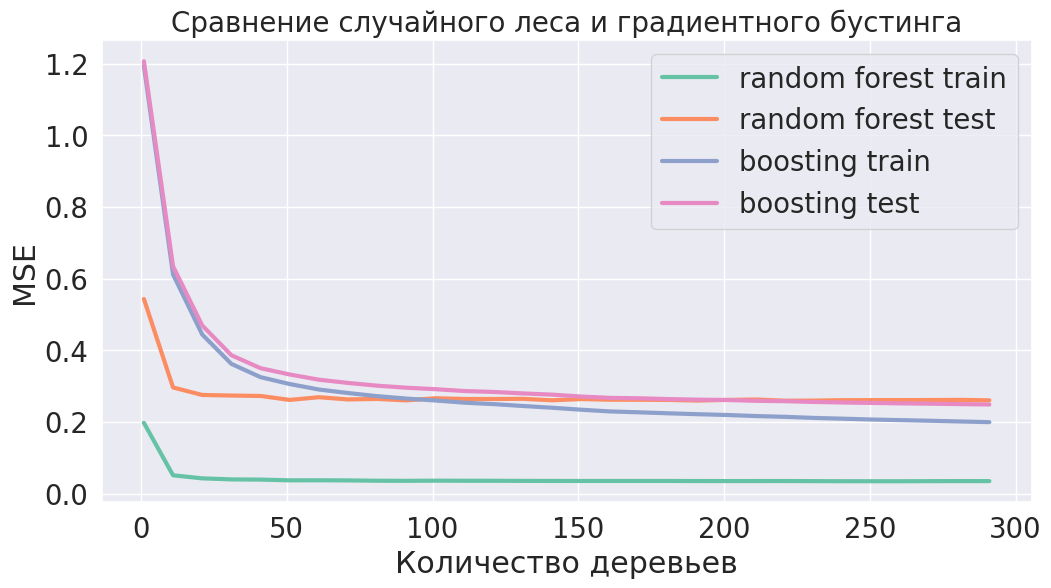

In [9]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid,
    [rf_mse_train, boosting_mse_train],
    [rf_mse_test, boosting_mse_test],
    'Количество деревьев', 'MSE',
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.** бустинг и случайный лес имеют одинаковые результаты на тесте при д остаточно большом числе деревьев. Тем не менее при числе экземпляров меньше 10 результаты случайного леса значительно лучше

Случайный лес имеет значительно больший зазор между ошибкой на train и test

Сравним времена обучения и предсказания случайного леса и градиентного бустинга с параметрами по умолчанию:

In [10]:
%%timeit

regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

4.92 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

In [13]:
%%timeit

regressor_boosting.predict(X_train)
pass

28.3 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit

regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

14.7 s ± 3.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

In [16]:
%%timeit

regressor_forest.predict(X_train)
pass

365 ms ± 95.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Вывод:** обучение случайного леса занимает больше времени при стандартных настройках. Это же верно и для времени предсказания

### 2 Задача классификации

Сделаем аналогичный эксперимент с датасетом для классификации рукописных цифр.

In [20]:
!wget https://archive.ics.uci.edu/static/public/59/letter+recognition.zip
!unzip letter+recognition.zip

--2023-11-03 23:25:15--  https://archive.ics.uci.edu/static/public/59/letter+recognition.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘letter+recognition.zip.1’

letter+recognition.     [  <=>               ] 378.09K  1.56MB/s    in 0.2s    

2023-11-03 23:25:16 (1.56 MB/s) - ‘letter+recognition.zip.1’ saved [387167]

Archive:  letter+recognition.zip
  inflating: Index                   
  inflating: letter-recognition.data  
  inflating: letter-recognition.data.Z  
  inflating: letter-recognition.names  


In [21]:
letters_df = pd.read_csv('letter-recognition.data', header=None)
print('shape:', letters_df.shape)
letters_df.head()

shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [23]:
X = letters_df.values[:, 1:]
y = letters_df.values[:, 0]

Разобьём данные на обучающую и тестовую выборки.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Обучим случайный лес для разного числа деревьев и посчитаем метрику `accuracy`.

In [25]:
rf_accuracy_train = []
rf_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    rf=RandomForestClassifier(n_estimators=n_estimators).fit(X_train,y_train)
    rf_accuracy_train.append(rf.score(X_train,y_train))
    rf_accuracy_test.append(rf.score(X_test,y_test))

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем метрику `accuracy`.

In [28]:
# стандартный бустинг учится слишком долго
from sklearn.ensemble import HistGradientBoostingClassifier
boosting_accuracy_train = []
boosting_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    boost=HistGradientBoostingClassifier(max_iter=n_estimators).fit(X_train,y_train)
    boosting_accuracy_train.append(boost.score(X_train,y_train))
    boosting_accuracy_test.append(boost.score(X_test,y_test))

  0%|          | 0/12 [00:00<?, ?it/s]

Построим график зависимости `accuracy` от количества базовых моделей.

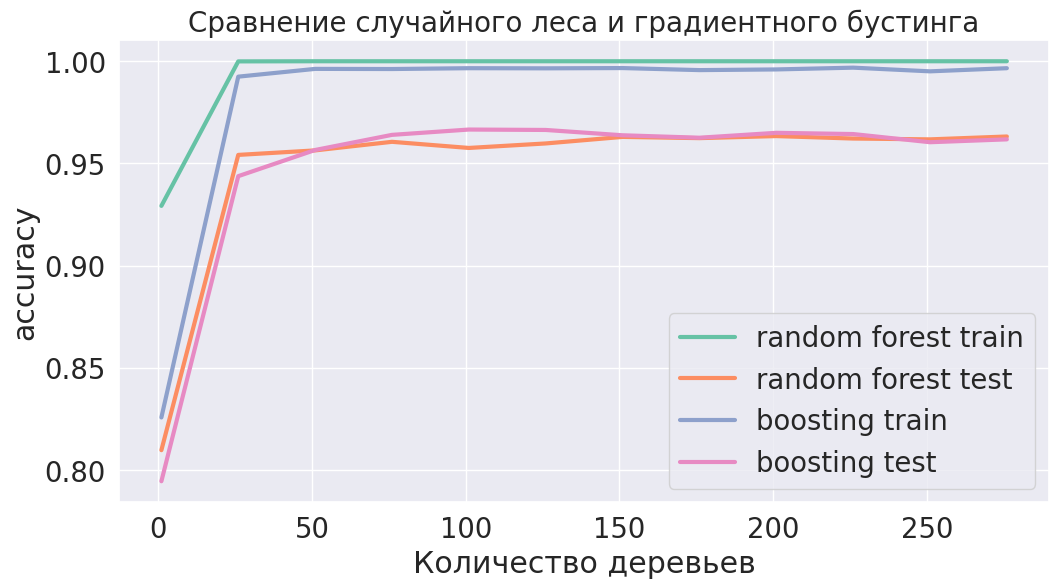

In [29]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid,
    [rf_accuracy_train, boosting_accuracy_train],
    [rf_accuracy_test, boosting_accuracy_test],
    'Количество деревьев', 'accuracy',
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.** кривые обучения бустига и случайного леса совпадают. Бустинг даже при использовании оптимизаций обучается дольше